In [1]:
# @title ResNet
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


100%|██████████| 170M/170M [00:06<00:00, 28.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


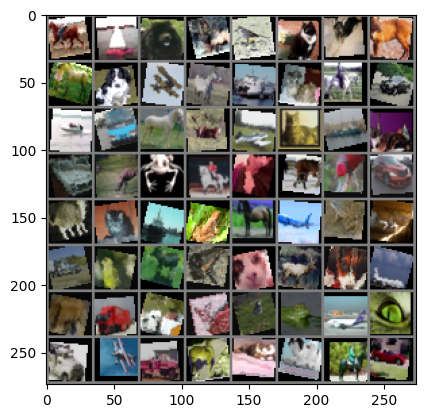

horse ship dog deer bird cat dog deer


In [2]:
# @title Datasets
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.dataset.classes

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(8)))


In [5]:
# @title Early Stopping
import numpy as np
import torch

class EarlyStopping:
    """Зупиняє навчання, якщо валідаційна втрата не покращується."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        """
        Args:
            patience (int): Скільки епох чекати без покращень (default: 7)
            verbose (bool): Виводити повідомлення про збереження моделі (default: False)
            delta (float): Мінімальне покращення для валідаційної втрати, яке вважається значним (default: 0)
            path (str): Шлях для збереження найкращої моделі (default: 'checkpoint.pth')
            trace_func (function): Функція для логування (default: print)
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Зберігає модель, якщо валідаційна втрата покращилась."""
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [3]:
# @title Train Model
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(net, device, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=30, patience=3):
    print(net)
    print(device)

    net.to(device)

    train_losses, val_losses = [], []

    # Ініціалізація EarlyStopping
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_model.pth')

    # Підготовка динамічного графіка
    plt.ion()  # Увімкнення інтерактивного режиму
    fig, ax = plt.subplots()
    ax.set_title("Training and Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    train_line, = ax.plot([], [], label="Train Loss", color="blue")
    val_line, = ax.plot([], [], label="Validation Loss", color="orange")
    ax.legend()

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Нульова ініціалізація градієнтів
            optimizer.zero_grad()

            # Прямий прохід
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Валідація
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

        # Оновлення графіка
        train_line.set_data(range(1, len(train_losses) + 1), train_losses)
        val_line.set_data(range(1, len(val_losses) + 1), val_losses)
        ax.set_xlim(0, num_epochs + 1)
        ax.set_ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
        fig.canvas.draw()
        fig.canvas.flush_events()

        # Виклик EarlyStopping
        early_stopping(val_losses[-1], net)

        # Перевірка, чи потрібно зупинити навчання
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Крок для Scheduler
        scheduler.step()

    # Завантажити найкращу модель
    net.load_state_dict(torch.load('best_model.pth'))

    # Завершення графіка
    plt.ioff()  # Вимкнення інтерактивного режиму
    plt.show()

    return train_losses, val_losses


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Epoch 1/30: 100%|██████████| 625/625 [00:58<00:00, 10.64it/s]


Epoch 1: Train Loss = 1.7745, Val Loss = 1.6057
Validation loss decreased (inf --> 1.605706). Saving model ...


Epoch 2/30: 100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


Epoch 2: Train Loss = 1.4547, Val Loss = 1.4151
Validation loss decreased (1.605706 --> 1.415143). Saving model ...


Epoch 3/30: 100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


Epoch 3: Train Loss = 1.2816, Val Loss = 1.2668
Validation loss decreased (1.415143 --> 1.266769). Saving model ...


Epoch 4/30: 100%|██████████| 625/625 [00:56<00:00, 11.04it/s]


Epoch 4: Train Loss = 1.1719, Val Loss = 1.1972
Validation loss decreased (1.266769 --> 1.197233). Saving model ...


Epoch 5/30: 100%|██████████| 625/625 [00:56<00:00, 10.98it/s]


Epoch 5: Train Loss = 1.1102, Val Loss = 1.1074
Validation loss decreased (1.197233 --> 1.107351). Saving model ...


Epoch 6/30: 100%|██████████| 625/625 [00:56<00:00, 11.01it/s]


Epoch 6: Train Loss = 1.0619, Val Loss = 1.1635
EarlyStopping counter: 1 out of 3


Epoch 7/30: 100%|██████████| 625/625 [00:56<00:00, 11.03it/s]


Epoch 7: Train Loss = 1.0230, Val Loss = 1.0284
Validation loss decreased (1.107351 --> 1.028414). Saving model ...


Epoch 8/30: 100%|██████████| 625/625 [00:56<00:00, 10.99it/s]


Epoch 8: Train Loss = 0.9855, Val Loss = 1.0050
Validation loss decreased (1.028414 --> 1.004997). Saving model ...


Epoch 9/30: 100%|██████████| 625/625 [00:56<00:00, 10.98it/s]


Epoch 9: Train Loss = 0.9599, Val Loss = 1.0308
EarlyStopping counter: 1 out of 3


Epoch 10/30: 100%|██████████| 625/625 [00:56<00:00, 11.02it/s]


Epoch 10: Train Loss = 0.9358, Val Loss = 0.9991
Validation loss decreased (1.004997 --> 0.999107). Saving model ...


Epoch 11/30: 100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


Epoch 11: Train Loss = 0.9181, Val Loss = 0.9464
Validation loss decreased (0.999107 --> 0.946390). Saving model ...


Epoch 12/30: 100%|██████████| 625/625 [00:56<00:00, 11.01it/s]


Epoch 12: Train Loss = 0.8981, Val Loss = 0.9286
Validation loss decreased (0.946390 --> 0.928598). Saving model ...


Epoch 13/30: 100%|██████████| 625/625 [00:56<00:00, 11.00it/s]


Epoch 13: Train Loss = 0.8851, Val Loss = 0.9049
Validation loss decreased (0.928598 --> 0.904872). Saving model ...


Epoch 14/30: 100%|██████████| 625/625 [00:56<00:00, 11.03it/s]


Epoch 14: Train Loss = 0.8660, Val Loss = 0.9422
EarlyStopping counter: 1 out of 3


Epoch 15/30: 100%|██████████| 625/625 [00:56<00:00, 11.03it/s]


Epoch 15: Train Loss = 0.8540, Val Loss = 0.9357
EarlyStopping counter: 2 out of 3


Epoch 16/30: 100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


Epoch 16: Train Loss = 0.8372, Val Loss = 0.8911
Validation loss decreased (0.904872 --> 0.891104). Saving model ...


Epoch 17/30: 100%|██████████| 625/625 [00:56<00:00, 11.04it/s]


Epoch 17: Train Loss = 0.8291, Val Loss = 0.8503
Validation loss decreased (0.891104 --> 0.850274). Saving model ...


Epoch 18/30: 100%|██████████| 625/625 [00:56<00:00, 11.04it/s]


Epoch 18: Train Loss = 0.8182, Val Loss = 0.8525
EarlyStopping counter: 1 out of 3


Epoch 19/30: 100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


Epoch 19: Train Loss = 0.8087, Val Loss = 0.8569
EarlyStopping counter: 2 out of 3


Epoch 20/30: 100%|██████████| 625/625 [00:57<00:00, 10.96it/s]


Epoch 20: Train Loss = 0.7932, Val Loss = 0.8440
Validation loss decreased (0.850274 --> 0.844032). Saving model ...


Epoch 21/30: 100%|██████████| 625/625 [00:57<00:00, 10.96it/s]


Epoch 21: Train Loss = 0.7878, Val Loss = 0.8240
Validation loss decreased (0.844032 --> 0.823962). Saving model ...


Epoch 22/30: 100%|██████████| 625/625 [00:56<00:00, 10.99it/s]


Epoch 22: Train Loss = 0.7835, Val Loss = 0.8680
EarlyStopping counter: 1 out of 3


Epoch 23/30: 100%|██████████| 625/625 [00:57<00:00, 10.91it/s]


Epoch 23: Train Loss = 0.7718, Val Loss = 0.8352
EarlyStopping counter: 2 out of 3


Epoch 24/30: 100%|██████████| 625/625 [00:56<00:00, 10.97it/s]


Epoch 24: Train Loss = 0.7669, Val Loss = 0.8305
EarlyStopping counter: 3 out of 3
Early stopping


<ipython-input-3-03ab83a9f062>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('best_model.pth'))


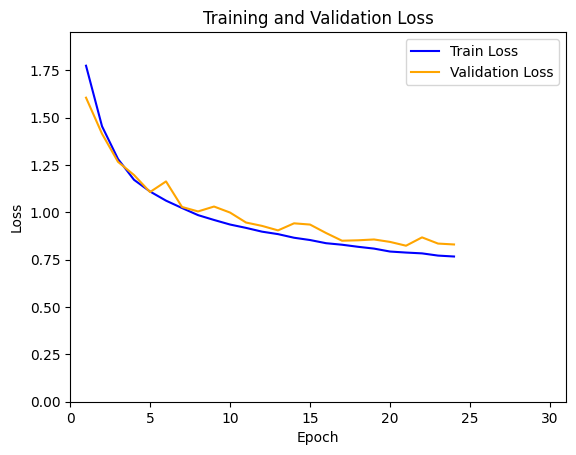

[1.7745200973510742, 1.4546791980743408, 1.2815764764785766, 1.1719465369224549, 1.1101989146232605, 1.0618666726112365, 1.0229962693214416, 0.9855126367568969, 0.9599216073989868, 0.9358403197288513, 0.9180779191970825, 0.8981442929267883, 0.8850936470031738, 0.8660473563194275, 0.8539558201789856, 0.8372007607460022, 0.8291381197929383, 0.8182251667976379, 0.8086793120384216, 0.7931709128379821, 0.7877877849578857, 0.7834708058357239, 0.7717540222167969, 0.7669259377479554] [1.6057056386000033, 1.415143178526763, 1.2667690826829072, 1.1972325280973106, 1.1073510958130952, 1.1634570060262255, 1.0284143447116683, 1.0049973897113922, 1.0308033375983026, 0.999107265927989, 0.9463902187954848, 0.9285983367330709, 0.9048721232232014, 0.9421574192441953, 0.9356642384437999, 0.8911041344047352, 0.8502736767386175, 0.8525216697127955, 0.8569070533582359, 0.8440319960284385, 0.8239619477539305, 0.8679734035662026, 0.8352252070311528, 0.8305351798701438]


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

net = ResNet34()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.0005, weight_decay=1e-4)  # weight_decay для L2-регуляризації
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=10
)

train_losses, val_losses = train_model(
    net=net,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
)

print(train_losses, val_losses)

In [7]:
# Завантаження найкращої моделі
import os
if os.path.exists("best_model.pth"):
    net.load_state_dict(torch.load("best_model.pth"))
else:
    print("Model file not found!")
    exit()

# Оцінка на тестових даних
net.eval()
test_loss = 0.0
correct = 0
total = 0
num_classes = 10
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        # Обчислення втрат
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        # Обчислення точності
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Класова точність
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

# Результати
test_loss /= total
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Точність для кожного класу
for i in range(num_classes):
    if class_total[i] > 0:
        print(f"Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")
    else:
        print(f"Accuracy of class {i}: No samples")


<ipython-input-7-c3c814b5c717>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("best_model.pth"))


Test Loss: 0.8351, Test Accuracy: 85.23%
Accuracy of class 0: 85.40%
Accuracy of class 1: 91.80%
Accuracy of class 2: 76.90%
Accuracy of class 3: 76.80%
Accuracy of class 4: 84.60%
Accuracy of class 5: 76.60%
Accuracy of class 6: 88.60%
Accuracy of class 7: 88.60%
Accuracy of class 8: 89.60%
Accuracy of class 9: 93.40%


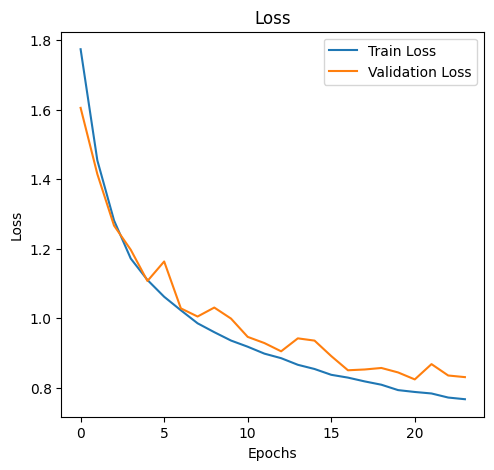

In [8]:
# Графіки втрат
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
